In [42]:
using DataFrames, CSV, CategoricalArrays
using Statistics, LinearAlgebra, Random
using Plots, ProgressBars

# Boston Data

In [157]:
    filename = "./datasets/Boston.csv"
    data = DataFrame(CSV.File(filename))
    df = copy(data)
    dropmissing!(df)
    ndf = names(df)

14-element Vector{String}:
 "crim"
 "zn"
 "indus"
 "chas"
 "nox"
 "rm"
 "age"
 "dis"
 "rad"
 "tax"
 "ptratio"
 "black"
 "lstat"
 "medv"

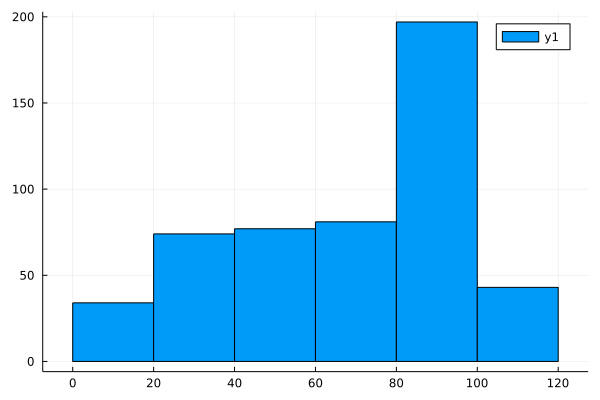

In [160]:
    name_of_y = :medv
    names_of_x =  ["rm", "lstat", "dis"] # 3:8
    names_of_z =[:age] # :pos
    dfy = df[!, name_of_y]
    dfX = df[!, names_of_x]
    dfZ = df[!, names_of_z]

    X, Z, y = Array(dfX), Array(dfZ), Array(dfy)
histogram(Z)

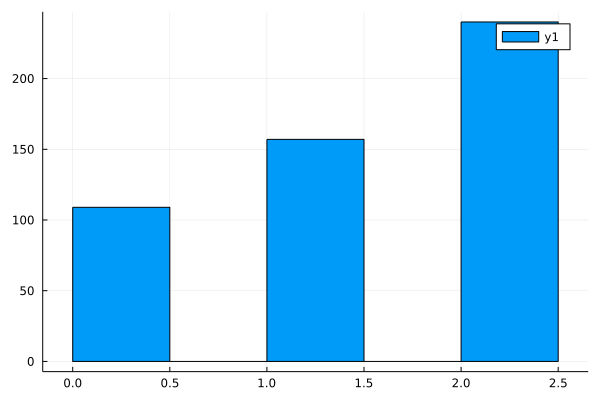

In [161]:
    Z = (Z .> 40) .+ (Z .> 80) .+ 0
    # Z = categ_binary(Z
histogram(Z)

# QGPLSIM fitting

In [162]:
include("./src/qgplsim.ji")
include("./src/supportFunctions.ji")
include("RealWorldData.ji")

califdata (generic function with 2 methods)

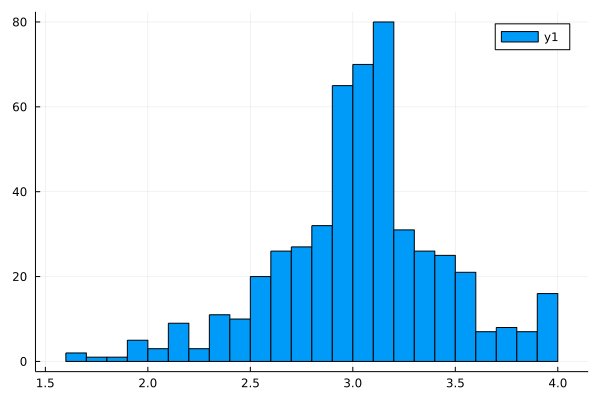

In [163]:
Xa, Za, ya = boston()
histogram(log.(ya))

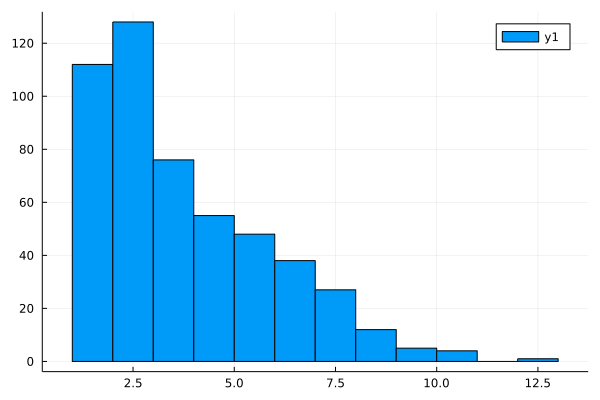

In [55]:
histogram(Xa[:,3])

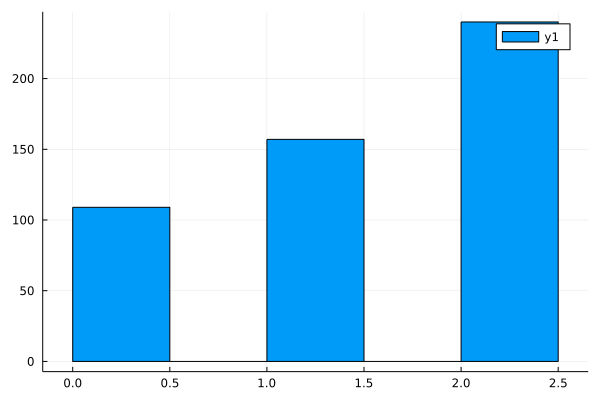

In [164]:
histogram(Za)

In [197]:
n_pt = 15
nmc = n_pt*Threads.nthreads()
mse = zeros(nmc)
t = 1
X = scaler(Xa, 1)
y = log.(ya)
Z = categ_binary(Za) # [:, 1]
categ, index = collection(Z)
n,p = size(X)  
n,q = size(Z)
ncateg = q + 1

prop = zeros(q + 1)
prop[1:q] = sum(Z, dims = 1) ./ n
prop[q + 1] = 1 - sum(prop)

ntrain = 400
ntest = n - ntrain
Theta = zeros(nmc, p)
Gamma = zeros(nmc, q)
Alpha = zeros(nmc, p)
Beta  = zeros(nmc, q)
widthExp = zeros(nmc)
each_ntrain = Int.(round.(ntrain .* prop))

indn = Array(1:n)
mc_indr = []
mc_indt = []
for mc in 1:nmc
    indr = []
    for k in 1:ncateg
        zk = categ[k]
        indzk = index[zk]
        indk = shuffle(1:length(indzk))
        indr = [indzk[indk[1:each_ntrain[k]]]; indr]
    end
    indt = [x in indr for x in indn]
    indt = Bool.(1 .- indt)
    push!(mc_indr, indr)
    push!(mc_indt, indt)   
end

In [201]:
mc_indt[1] |> sum

106

In [213]:
# width_exp = -0.17
width_exp = 0

tau = [0.5]
dv_order = 2
method = "mean" # mean for mean regression, optim and mm for qr regression
# tau = [0.25, 0.5,  0.75]
@threads for i in 1:Threads.nthreads()
    for j in tqdm(1:n_pt)
    t = (i - 1)*n_pt + j 

    indr = mc_indr[t]
    indt = mc_indt[t]

    Xr = X[indr, :]
    yr = y[indr] 
    Zr = Z[indr, :]

    Xt = X[indt, :]
    yt = y[indt]  
    Zt = Z[indt, :]
    # Zr = Zr .* 0
    # Zt = Zt .* 0
    qsmodel = qgplsim.model(Xr, Zr, yr, tau, width_exp)

    # qsmodel1 = qgplsim.model(Xr, Zr, yr, 0.1)
    # qsmodel9 = qgplsim.model(Xr, Zr, yr, 0.9)
    # @time qgplsim.estimator(qsmodel1)
    # @time qgplsim.estimator(qsmodel9)

    Theta[t, :], Gamma[t, :],
    Alpha[t, :], Beta[t, :] = qgplsim.estimator(qsmodel)
    widthExp[t] = qsmodel.widthExp
        
    vv = Xt * qsmodel.alpha
    ylx = Xt * qsmodel.theta
    ylz = Zt * qsmodel.beta
    yp = qgplsim.predict(qsmodel, Xt, Zt, dv_order) + ylx  + ylz
    # bias = rho.(yt - yp, tau)./2
    bias = (yp - yt).^2
    res = sum(bias) / ntest
    mse[t] = res 
    end
end

0.0%┣0.0%0.0%0.0%┣┣┣                                                  ┫                                                                                                                                           0/15 [00:00<00:-1, -0s/it]┫ ┫ ┫ 0/15 [00:00<00:-1, -0s/it]0/15 [00:00<00:-1, -0s/it]
0/15 [00:00<00:-1, -0s/it]


6.7%┣██▉                                        ┫ 1/15 [00:28<Inf:Inf, InfGs/it]
6.7%┣██▉                                        ┫ 1/15 [00:29<Inf:Inf, InfGs/it]
6.7%┣██▉                                        ┫ 1/15 [00:30<Inf:Inf, InfGs/it]
6.7%┣██▉                                        ┫ 1/15 [00:30<Inf:Inf, InfGs/it]
13.3%┣██████▏                                       ┫ 2/15 [00:58<12:37, 58s/it]
13.3%┣██████▏                                       ┫ 2/15 [00:59<12:46, 59s/it]
13.3%┣██████▏                                       ┫ 2/15 [01:00<13:00, 60s/it]
13.3%┣██████▏                                       ┫ 2/15 [01:00<13:00, 60s/it]
20.0%┣█████████▏            

In [220]:
mean(Theta, dims = 1)

1×3 Matrix{Float64}:
 0.13034  0.0610088  0.441002

In [221]:
mean(Alpha, dims = 1)

1×3 Matrix{Float64}:
 0.19511  -0.247573  -0.0205075

In [222]:
mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 0.0205121  0.0224669

In [223]:
mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.0177933  0.0766973

In [224]:
mean(mse)

0.09456250796179932

In [216]:
mse

60-element Vector{Float64}:
 0.05398029596808782
 0.08922338503499776
 0.08343016035069095
 0.07203550795203544
 0.06298867509154828
 0.05804011452459565
 0.18492709591496667
 0.03929290947687473
 0.06800693697106769
 0.21416098801094371
 0.2699243606635587
 0.06721591167911398
 0.06170158412396168
 ⋮
 0.07898371604439133
 0.055635353136878174
 0.06880767064975665
 0.23626128488808798
 0.06468521667994097
 0.06723261869142194
 0.042075717829258855
 0.042677193687445505
 0.04752185110565251
 0.10676737341204756
 0.043411898845026844
 0.23974392054208443

In [215]:
mse_no_z # = copy(mse)

60-element Vector{Float64}:
 0.05451009404140918
 0.0596397196332842
 0.06313086181481131
 0.0764665637333261
 0.07354266753089067
 0.04418963596574638
 0.05842437074765107
 0.057505780311619355
 0.06827198442462212
 0.06252157970721159
 0.07140799700160527
 0.06412680260571758
 0.06714994243758185
 ⋮
 0.07777791365065395
 0.049077152897948145
 0.1815815032422703
 0.07006699990299091
 0.07011065626064462
 0.059968926906067505
 0.0443582957486677
 0.03848665041855425
 0.057067060341095426
 0.08326176874103351
 0.04593533215656755
 0.061788946970579336

In [187]:
mean(mse_no_z)

0.08047763156543508

In [217]:
widthExp

60-element Vector{Float64}:
 -0.08
  0.1
 -0.035
 -0.05
 -0.05
 -0.125
  0.1
 -0.08
 -0.05
  0.1
  0.1
  0.1
  0.01
  ⋮
  0.025
 -0.2
 -0.08
 -0.02
 -0.035
 -0.05
 -0.005
 -0.065
 -0.065
 -0.08
 -0.005
  0.1